In [1]:
# Setup: Add src to path and create directories
import sys, os
sys.path.insert(0, os.path.join('..', 'src'))
for d in ['results', 'models']: 
    os.makedirs(f'../{d}', exist_ok=True)
print("✅ Setup complete: paths and directories ready")


✅ Setup complete: paths and directories ready


# Mercado Libre – Item Condition Challenge  
## Predicción de `new` vs `used`

> **Autor:** Juan Ignacio Dominguez – Senior DS   
> **Objetivo:** obtener **accuracy ≥ 0.86** y una métrica secundaria justificable.

Instalación de dependencias

In [2]:
# !pip install -q pandas==2.2.2 scikit-learn==1.5.0 lightgbm==4.3.0 shap

Imports & setup

In [3]:
import numpy as np
import pandas as pd
import json
import unicodedata
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from pandas.api.types import is_scalar
from datetime import timedelta
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import category_encoders as ce
# from sklearn.model_selection import KFold

# Reproducibilidad
np.random.seed(42)

# Estilo de display
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 50)

from new_or_used import build_dataset

Ingesta de Datos: *Cargamos splits pre-definidos*

In [4]:
X_train, y_train, X_test, y_test = build_dataset()

Conversión a DataFrame tabular

In [5]:
def dicts_to_df(dict_list):
    """
    Flatten nested JSON records into a pandas DataFrame.
    Nested keys are concatenated with '_'
    """
    return pd.json_normalize(dict_list, sep='_')

In [6]:
df_train = dicts_to_df(X_train)
df_test  = dicts_to_df(X_test)

df_train.head(3)

,warranty,sub_status,condition,deal_ids,base_price,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,shipping_local_pick_up,shipping_methods,shipping_tags,shipping_free_shipping,shipping_mode,shipping_dimensions,shipping_free_methods
0,None,[],new,[],80.0,"[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,True,[],[],False,not_specified,None,NaN
1,NUESTRA REPUTACION,[],used,[],2650.0,"[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,2650.0,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,True,[],[],False,me2,None,NaN
2,None,[],used,[],60.0,"[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7367189936,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,True,[],[],False,me2,None,NaN


In [7]:
print(f"Train rows: {df_train.shape[0]:,} | Train cols: {df_train.shape[1]:,} | "
      f"Test rows: {df_test.shape[0]:,} | Test cols: {df_test.shape[1]:,}")

Train rows: 90,000 | Train cols: 56 | Test rows: 10,000 | Test cols: 55


Chequeo la distribución de la variable target

In [8]:
df_train['condition'].value_counts(normalize=True).rename('proportion')

condition
new     0.537244
used    0.462756
Name: proportion, dtype: float64

Balance – `new` ≈ 54 % vs `used` ≈ 46 % → dataset casi balanceado

# 1. EDA Inicial: Analisis general de la estructura de datos

Lo primero que hacemos es verificar como es la estructura de cada una de las variables. Esto nos permite entender:

* Si hay valores duplicados.
* Formas distintas en las que se presenta la misma informacion dentro de una variable. Ejemplo: en 'warranty', se presenta de muchas formas distinas la palabra "Sí", "SI", "si", "si.", "Si".
* Redefinicion del tipo de ciertas variables. Ejemplo: variables que son categoricas o temporales, pero que vienen inicialmente en formato numerico.
* Formas en las que se presentan valores nulos o raros y los posibles tratamientos que podemos aplicar.
* Entender que variables son muy complejas de procesar en un inicio o pueden no aportar demasiada información.

Luego de esto vamos a poder analizar **duplicados, missing values y cardinalidad** para decidir que features dejaremos y realizar limpieza. Ademas deberemos **normalizar** algunas variables y simplificar la estructura de otras a **binary**.

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   warranty                          35243 non-null  object 
 1   sub_status                        90000 non-null  object 
 2   condition                         90000 non-null  object 
 3   deal_ids                          90000 non-null  object 
 4   base_price                        90000 non-null  float64
 5   non_mercado_pago_payment_methods  90000 non-null  object 
 6   seller_id                         90000 non-null  int64  
 7   variations                        90000 non-null  object 
 8   site_id                           90000 non-null  object 
 9   listing_type_id                   90000 non-null  object 
 10  price                             90000 non-null  float64
 11  attributes                        90000 non-null  object 
 12  buyi

In [10]:
# funcion para inspeccionar de manera individual cada feature. La usaremos más adelante
def inspect_column(df: pd.DataFrame, col: str, top_n: int = 10):
    s = df[col].astype('string')
    print(f"\n— {col} —")
    print("dtype:", df[col].dtype, "| n_missing:", s.isna().sum(),
          "| unique:", s.nunique(dropna=True))
    display(s.value_counts(dropna=True).head(top_n).to_frame('freq'))

In [11]:
# helper: valor hasheable seguro para listas, dicts y arrays
def _to_hashable(v):
    if not is_scalar(v):
        return str(v)
    if v is None:
        return pd.NA
    if isinstance(v, float) and math.isnan(v):
        return pd.NA
    if pd.isna(v):
        return pd.NA
    return v

In [12]:
# función de resumen
def quick_overview(df: pd.DataFrame, top_n: int = 3) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        s = df[col]
        dtype_orig = s.dtype

        s_hash = s.map(_to_hashable)

        row = {
            'col': col,
            'dtype': dtype_orig,
            'n_missing': s.isna().sum(),
            'missing_pct': round(100 * s.isna().mean(), 2),
            'n_unique': s_hash.nunique(dropna=True),
        }

        vc = s_hash.value_counts(dropna=True).head(top_n)
        for i, (val, cnt) in enumerate(vc.items(), 1):
            row[f'top{i}']  = val
            row[f'freq{i}'] = cnt

        rows.append(row)

    return pd.DataFrame(rows)

In [13]:
overview = quick_overview(df_train, top_n=3)

## Visualizacion de la tabla, ordenando por columnas con más nulos o valores unicos.

In [14]:
display(overview.sort_values(['missing_pct', 'freq1'], ascending=False).head(21).reset_index(drop=True))

,col,dtype,n_missing,missing_pct,n_unique,top1,freq1,top2,freq2,top3,freq3
0,differential_pricing,object,90000,100.00,0,NaN,NaN,NaN,NaN,NaN,NaN
1,subtitle,object,90000,100.00,0,NaN,NaN,NaN,NaN,NaN,NaN
2,catalog_product_id,float64,89993,99.99,7,800744.0,1.0,5093232.0,1.0,3050291.0,1.0
3,shipping_dimensions,object,89978,99.98,13,"33x20x12,300",4.0,"30x30x30,650",3.0,"33x20x12,400",2.0
4,original_price,float64,89870,99.86,105,750.0,3.0,850.0,3.0,1500.0,3.0
5,official_store_id,float64,89255,99.17,193,1580.0,37.0,6448.0,27.0,6732.0,23.0
6,video_id,object,87324,97.03,1886,QQNfOicE_o8,278.0,EVCQuwl7RIE,82.0,mYNRC5Ia1sk,35.0
7,shipping_free_methods,object,87311,97.01,5,"[{'rule': {'value': None, 'free_mode': 'countr...",2641.0,"[{'rule': {'value': None, 'free_mode': 'countr...",37.0,"[{'rule': {'value': None, 'free_mode': 'countr...",6.0
8,warranty,object,54757,60.84,9536,Sí,5107.0,Sin garantía,4907.0,SI,545.0
9,parent_item_id,object,20690,22.99,69310,MLA3661010119,1.0,MLA6553902747,1.0,MLA7727150374,1.0


## Analisis de variables con mayor % de nulos o valores unicos (Top-21)

### 1. Vista general de la tabla
* **Seis columnas** exhiben **≥ 99 %** de valores faltantes; es prácticamente imposible obtener información util de algo que casi nunca está presente.
* Hay varios campos “sin nulos” pero **monovalentes**: su `freq1` abarca ~100 % de los registros — son constantes disfrazadas y no añaden ninguna capacidad de segmentación.
* En varias features (`shipping_methods`, `coverage_areas`, `shipping_tags`, etc.) el valor modal es `[]`. Esa lista vacía es, en la práctica, un **nulo codificado de otra forma** y requiere normalización antes de cualquier encoding. Otras como `listing_source` tiene el campo `' '`. → Seria conveniente armar un pipe robusto que primero identifique bien las columnas con nulos.

---

### 2. Diagnóstico por columna

| Columna | % NA | n_unique | Hallazgos clave & acción preliminar |
|---------|:----:|------:|-------------------------------------|
| **differential_pricing** | 100 | 0 | Jamás se utiliza → **descartar sin discusión**. |
| **subtitle** | 100 | 0 | Campo siempre vacío → **descartar**. |
| **catalog_product_id** | 99.99 | 7 | 7 IDs distintos en todo el set, resto vacío. Valor potencial: un simple <br>flag “ligado a catálogo”. |
| **shipping_dimensions** | 99.98 | 13 | Texto con “LxAxH,peso”, presente en <0.02 % de filas. Ruido puro → **descartar**. |
| **original_price** | 99.86 | 105 | Sólo ~130 registros; preferimos derivar descuentos desde `price` vs `base_price`. → **descartar**. |
| **official_store_id** | 99.17 | 193 | Muy nula, pero señala “vende como tienda oficial”. <br>💡 Generar flag `is_official_store`. |
| **video_id** | 97.03 | 1 886 | Apenas 3 % de listings incluyen video. <br>💡 Flag `has_video`; el ID como tal sobra. |
| **shipping_free_methods** | 97.01 | 5 | Lista JSON; casi siempre vacía. <br>💡 Flag `has_free_methods`; descartar el contenido. |
| **warranty** | 60.84 | 9 536 | Gran promiscuidad: «Sí», «SI», «si», «Sin garantía»… Requiere **normalizar tildes/caso** y agrupar. |
| **parent_item_id** | 22.99 | 69 310 | Alta cardinalidad, 23 % nulo. Identifica variaciones de un ítem “padre”. Candidato a **hash encoding** o a descartar si no aporta. |
| **shipping_methods** | 2.99 | 1 | El 97 % son lista vacía `[]` ≡ nulo codificado diferente y el otro 3% son nulos. Sin señal → **descartar**. |
| **site_id** | 0 | 1 | Valor constante (`'MLA'`). Aporta “0” de información → **descartar**. |
| **listing_source** | 0 | 1 | Misma situación: `MLA` en 100 % de casos ⇒ **descartar**. |
| **coverage_areas** | 0 | 1 | Campo contiene siempre `[]`. Ruido puro ⇒ **descartar**. |
| **international_delivery_mode** | 0 | 1 | Valor fijo `none`. Aporta cero ⇒ **descartar**. |
| **seller_address_country_name** | 0 | 2 | `Argentina` (99.9 %). Redundante como `site_id`. **Descartar**. |
| **seller_address_country_id** | 0 | 2 | `AR` casi exclusivo. Igual que el anterior ⇒ **descartar**. |
| **shipping_tags** | 0 | 3 | 99.3 % `[]`; ocasional `['relisted_with_modifications']` o `['free_method_upgraded']`.  <br>💡 Usar flag `has_shipping_tag`, luego **descartar lista**. |
| **deal_ids** | 0 | 31 | 99.8 % `[]`; ínfimo set de códigos (`['MOSH6']`, …). Codificar y ver el poder explicativo, sino → **descartar**. |
| **currency_id** | 0 | 2 | `ARS` (99.4 %) vs `USD` (0.6 %). El mix ARS/USD puede ser señal ⇒ **mantener** (one-hot). |

---

### 3. Decisiones inmediatas

| Acción | Columnas |
|--------|----------|
| **Descartar sin dudas** | `differential_pricing`, `subtitle`, `shipping_dimensions`, `original_price`, `shipping_methods`, `site_id`, `listing_source`, `coverage_areas`, `international_delivery_mode`, `seller_address_country_name`, `seller_address_country_id`, `deal_ids`  |
| **Mantener como *flag o binary* (presencia/ausencia)** |`catalog_product_id` → `has_catalog_id`  •  `official_store_id` → `is_official_store`  •  `video_id` → `has_video`  •  `shipping_free_methods` → `has_free_methods`  •  `shipping_tags` → `has_shipping_tag` |
| **Mantener con limpieza/encoding** |`warranty` → normalizar texto y agrupar en pocas categorías (`garantía_sí/no`, `garantía_meses`, etc.)  •  `parent_item_id` → hash-encode o evaluar impacto  •  `currency_id` → one-hot (ARS vs USD) |

⇒ *Con este analisis inicial podemos armar un pipeline que primero estandarice los valores nulos y elimine aquellas features con 100% nulos. Lo mismo para categorias con un solo valor que no aportan información.*

## Visualizacion de la tabla, ordenando por columnas con mayor cardinalidad

In [15]:
display(overview.sort_values('n_unique', ascending=False).head(14).reset_index(drop=True))

,col,dtype,n_missing,missing_pct,n_unique,top1,freq1,top2,freq2,top3,freq3
0,id,object,0,0.00,90000,MLA5576008214,1.0,MLA7057298505,1.0,MLA3658983139,1.0
1,permalink,object,0,0.00,90000,http://articulo.mercadolibre.com.ar/MLA5576008...,1.0,http://articulo.mercadolibre.com.ar/MLA7057298...,1.0,http://articulo.mercadolibre.com.ar/MLA3658983...,1.0
2,pictures,object,0,0.00,89294,[],703.0,"[{'size': '250x250', 'secure_url': 'https://a2...",4.0,"[{'size': '250x250', 'secure_url': 'https://a2...",2.0
3,thumbnail,object,0,0.00,89260,,703.0,http://www.mercadolibre.com/jm/img?s=STC&v=I&f...,35.0,http://mla-s1-p.mlstatic.com/6279-MLApp_27_214...,4.0
4,secure_thumbnail,object,0,0.00,89260,,703.0,https://www.mercadolibre.com/jm/img?s=STC&v=I&...,35.0,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,4.0
5,title,object,0,0.00,89008,50 Suspensores Para Short De Baño Tela Calada,66.0,50 Suspensores Para Short De Baño Nido De Abeja,45.0,Confeccion Short De Baño Bermudas Hombre Y Niño,32.0
6,descriptions,object,0,0.00,87584,[],2417.0,"[""{'id': 'MLA6446532258-932171539'}""]",1.0,"[""{'id': 'MLA6573595104-928825450'}""]",1.0
7,last_updated,object,0,0.00,86015,2015-09-18T13:20:41.000Z,6.0,2015-09-30T12:20:39.000Z,6.0,2015-09-18T13:21:35.000Z,6.0
8,date_created,object,0,0.00,79247,2015-09-17T18:26:59.000Z,7.0,2015-09-28T14:10:39.000Z,7.0,2015-09-15T12:02:24.000Z,7.0
9,start_time,int64,0,0.00,78890,1443449439000,7.0,1442514419000,7.0,1444689463000,7.0


## Análisis de variables con mayor cardinalidad (`n_unique` Top-14)

### 1. Vista general  
* Varias columnas son **identificadores únicos o URLs**: `id`, `permalink`, distintos thumbnails. Cada fila trae un valor exclusivo → **no aportan señal** (sólo ruido y overfitting).  
* Otras almacenan **listas** (`pictures`, `descriptions`) cuyo contenido varía casi línea por línea; conviene resumirlas a contadores o flags.  
* Aparecen **timestamps crudos** (`start_time`, `stop_time`, `last_updated`, `date_created`) en string o epoch; mejor derivar duraciones/antigüedad y descartar el original.  
* `title`, `seller_id`, `category_id` sí contienen información útil pese a la alta cardinalidad.

---

### 2. Diagnóstico por columna

| Columna | n_unique | Observaciones & acción preliminar |
|---------|------:|-----------------------------------|
| **id** | 90 000 | Identificador único por ítem. Peligro de identity leakage y overfitting → **descartar**. |
| **permalink** | 90 000 | URL exclusiva; mismo problema que `id`. **Descartar**. |
| **pictures** | 89 294 | Lista de dicts con URLs y tamaños. <br> 💡 **Extraer** `n_pictures` y descartar la lista. A lo mejor extraemos algo mas sobre la resolución de la imagen en una fase 2. |
| **thumbnail / secure_thumbnail** | 89 260 | URL casi única para cada ítem; duplican información de `pictures`. **Descartar**. |
| **title** | 89 008 | Texto descriptivo clave. **Mantener** y procesar con **TF-IDF**. |
| **descriptions** | 87 584 | Lista/JSON de descripción extendida. <br> 💡 Por ahora **extraer** `has_description` o `n_description_blocks`; dejar contenido completo para una fase 2. |
| **last_updated** | 86 015 | Timestamp ISO. Convertir a `datetime`, derivar **delta tiempo** y luego descartar crudo. |
| **date_created** | 79 247 | Idem anterior. |
| **start_time / stop_time** | 78 890 / 78 486 | Epoch ms → **derivar** `listing_duration_days`, `item_age_days`; luego descartar crudo. |
| **parent_item_id** | 69 310 | Identifica ítem padre (variaciones). Alta cardinalidad pero posible señal de “familia” de producto. → **Hash-encode** y conservar. |
| **seller_id** | 33 281 | Indicador de vendedor. **Mantener** con **hashing** (riesgo de one-hot gigantesco). |
| **category_id** | 10 491 | Taxonomía MELI. **Señal fundamental; mantener** con **target encoding** o one-hot recortado. |

---

### 3. Decisiones inmediatas

| Acción | Columnas implicadas |
|--------|--------------------|
| **Descartar sin dudas** | `id`, `permalink`, `thumbnail`, `secure_thumbnail` |
| **Resumen por recuento / flag** | `pictures` → `n_pictures` · `descriptions` → `has_description` / `n_desc_blocks` |
| **Transformar timestamps** | `last_updated`, `date_created`, `start_time`, `stop_time` → convertir a `datetime`, luego derivar `listing_duration_days`, `item_age_days` y eliminar originales |
| **Mantener con encoding adecuado** | `title` → TF-IDF · `seller_id` → hashing · `parent_item_id` → hashing · `category_id` → target / reduced one-hot |

⇒ *Con estas decisiones controlamos la explosión de cardinalidad, prevenimos data leakeage y nos quedamos con la información verdaderamente útil para el modelo.*

## Por ultimo, analizamos  las variables que no entraron en los dos casos anteriores

In [16]:
pending_cols = [
    'sub_status', 'non_mercado_pago_payment_methods', 'variations', 'listing_type_id', 'buying_mode', 
    'tags', 'automatic_relist', 'status', 'attributes', 'base_price', 'price', 'seller_address_state_name', 
    'seller_address_state_id', 'seller_address_city_name', 'seller_address_city_id', 'shipping_local_pick_up',
    'shipping_free_shipping', 'shipping_mode', 'initial_quantity', 'sold_quantity', 'available_quantity'
   ]

In [17]:
overview_pending = quick_overview(df_train[pending_cols], top_n=3)

In [18]:
display(overview_pending.drop(['n_missing', 'missing_pct'], axis=1).sort_values('freq1', ascending=False).head(22).reset_index(drop=True))

,col,dtype,n_unique,top1,freq1,top2,freq2,top3,freq3
0,sub_status,object,4,[],89109,['suspended'],871,['expired'],13.0
1,buying_mode,object,3,buy_it_now,87311,classified,1982,auction,707.0
2,shipping_free_shipping,bool,2,False,87303,True,2697,NaN,NaN
3,status,object,4,active,86116,paused,3863,closed,20.0
4,automatic_relist,bool,2,False,85773,True,4227,NaN,NaN
5,variations,object,7375,[],82626,[{'attribute_combinations': [{'value_id': '920...,1,[{'attribute_combinations': [{'value_id': '920...,1.0
6,attributes,object,3118,[],78850,"[{'value_id': 'female', 'attribute_group_id': ...",1039,"[{'value_id': 'female', 'attribute_group_id': ...",997.0
7,sold_quantity,int64,304,0,74834,1,5924,2,2246.0
8,shipping_local_pick_up,bool,2,True,71577,False,18423,NaN,NaN
9,tags,object,8,['dragged_bids_and_visits'],65315,[],22412,"['good_quality_thumbnail', 'dragged_bids_and_v...",1191.0


## Análisis de variables restantes

### 1. Vista general  
* La mayoría de estas columnas **son utiles** y se reparte en dos grandes grupos:
  * **List-like / JSON** con la lista vacía `[]` como valor modal (`variations`, `attributes`, `non_mercado_pago_payment_methods`).
  * **Booleans / categóricas muy sesgadas** (`shipping_free_shipping`, `buying_mode`, `status`, …) donde un solo valor domina > 70 % del set.
  * **Identificadores/contadores** con cola larga (`seller_address_city_id`, `initial_quantity`, etc.).
* Los contadores de inventario (`sold_quantity`, `available_quantity`) y los flags de logística muestran *long tail* de valores bajos (0-3 unidades).
* Las numéricas de precio muestran miles de valores distintos — habitual en features continuas — pero `base_price` es casi réplica de `price`.  
* Algunas columnas tienen cardinalidad moderada (4–25) y son buenas candidatas para **one-hot** (`listing_type_id`, `shipping_mode`, `seller_address_state_name`).
* Con esta foto podemos decidir qué campos degradar a **flag / count** y cuáles merecen un encoding más elaborado.

---

### 2. Diagnóstico por columna

| Columna | n_unique | Observaciones & acción preliminar |
|---------|------:|-----------------------------------|
| **sub_status** | 4 | 99 % `[]`; ocasional `'suspended'`, `'expired'`. → Flag `has_sub_status` y descartar texto. |
| **buying_mode** | 3 | 97 % `buy_it_now`, resto `classified` / `auction`. → Mantener one-hot (poca cardinalidad). |
| **shipping_free_shipping** | 2 | 97 % `False`, 3 % `True`. → Mantener como **variable binaria** (ya lo es). |
| **status** | 4 | 95 % `active`; `paused`, `closed` minoritarios. → Mantener como cat. pequeña; posible señal de disponibilidad. → One-hot (pocas categorías).|
| **automatic_relist** | 2 | 95 % `False`. → Mantener como flag. |
| **variations** | 7 375 | 92 % `[]`; resto JSON con combinaciones. → Derivar `n_variations` (len(lista)) y descartar lista. |
| **attributes** | 3 118 | 87 % `[]`. → Derivar `n_attributes` y, a futuro, extraer `brand` / `item_condition` en una fase 2. |
| **sold_quantity** | 304 | 83 % `0`, cola larga. → Mantener numérica + usar en `sell_through_rate`. |
| **shipping_local_pick_up** | 2 | 80 % `True`. → Mantener como flag binaria (podría correlacionar con “usado”). |
| **tags** | 8 | 72 % `['dragged_bids_and_visits']`, 24 % `[]`. → Flag `has_tags`, quizá one-hot de etiquetas más frecuentes. |
| **available_quantity** | 441 | 70 % `1`, luego cola larga. → Mantener numérica + derivar `stock_remaining_pct`. |
| **initial_quantity** | 425 | 70 % `1`; muy correlacionada con `sold_quantity + available`. → Mantener para ratio, descartar si causa multicolinealidad. |
| **listing_type_id** | 7 | `bronze` 63 %, `free` 21 %, `silver` 9 %… → One-hot (baja cardinalidad). |
| **seller_address_state_name / _id** | 25 | Provincias (Buenos Aires 35 k, CABA 5 k…). → One-hot o target-encode; aporta señal geográfica. |
| **seller_address_city_id / _name** | 285 / 3 480 | Alta cardinalidad; mantener con **hashing** o agrupar ciudades top-N y resto «other». |
| **shipping_mode** | 4 | `me2` 51 %, `not_specified` 45 %, `custom` 3 %. → One-hot. |
| **non_mercado_pago_payment_methods** | 174 | 31 k registros con `[]`; resto JSON con métodos externos. → Flag `has_other_payments`. |
| **base_price** | 9 594 | Casi duplicado de `price`; ρ≈1.0. → **Descartar** y calcular `discount_pct` con `price`. |
| **price** | 9 595 | Valor continuo clave. → Mantener; crear `log1p_price`. |

---

### 3. Decisiones inmediatas

| Acción | Columnas |
|--------|----------|
| **Descartar** | `base_price` |
| **Reducir a flag / count** | `sub_status`, `variations`, `attributes`, `tags`, `non_mercado_pago_payment_methods` |
| **Mantener binaria** | `shipping_free_shipping`, `automatic_relist`, `shipping_local_pick_up` |
| **Mantener one-hot** | `buying_mode`, `status`, `listing_type_id`, `shipping_mode`, `seller_address_state_name`, `seller_address_state_id` |
| **Mantener high-card encoding** | `seller_address_city_id`, `seller_address_city_name` |
| **Mantener numéricas + métricas derivadas** | `price`, `sold_quantity`, `available_quantity`, `initial_quantity` (→ `sell_through_rate`, `stock_remaining_pct`) |

⇒ *Con esta lista final terminamos la fase de diagnóstico de features: sabemos qué descartar, qué simplificar en flags/binary y qué conservar con el encoding apropiado/feature engineering antes de construir el pipeline de modelado.*

# 2. Feature Engineering & Feature Selection & Feature Creation

## 2.1 Columnas a descartar por completo

In [19]:
DROP_COLS = [
    'differential_pricing', 'subtitle', 'shipping_dimensions', 'original_price',
    'shipping_methods', 'site_id', 'listing_source', 'coverage_areas',
    'international_delivery_mode', 'seller_address_country_name',
    'seller_address_country_id', 'deal_ids', 'id', 'permalink',
    'thumbnail', 'secure_thumbnail', 'base_price'
]

In [20]:
df_train = df_train.drop(columns=DROP_COLS, errors='ignore')
df_test  = df_test.drop(columns=DROP_COLS,  errors='ignore')

print("Columnas eliminadas:", len(DROP_COLS))
print("Nuevo shape  →  Train:", df_train.shape, "| Test:", df_test.shape)

Columnas eliminadas: 17
Nuevo shape  →  Train: (90000, 39) | Test: (10000, 38)


## 2.2 Convertir IDs numéricos en categóricos: Columnas que terminan en “`_id`” las casteamos a `object` para tratarlas como categóricas.

In [21]:
id_num_cols = df_train.filter(regex=r'_id$', axis=1).select_dtypes(include='number').columns.tolist()

print(f"IDs numéricos detectados ({len(id_num_cols)}):", id_num_cols)

for col in id_num_cols:
    df_train[col] = df_train[col].astype('string')
    df_test[col]  = df_test[col].astype('string')

IDs numéricos detectados (3): ['seller_id', 'official_store_id', 'catalog_product_id']


## 2.3 Normalizar columnas temporales.

In [22]:
TS_COLS = [c for c in ['start_time', 'stop_time', 'last_updated', 'date_created']
           if c in df_train.columns]

def to_datetime_naive(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        s = pd.to_datetime(s, unit='ms', errors='coerce', utc=True)
    else:
        s = pd.to_datetime(s, errors='coerce', utc=True)
    return s.dt.tz_localize(None)

In [23]:
for col in TS_COLS:
    df_train[col] = to_datetime_naive(df_train[col])
    df_test[col]  = to_datetime_naive(df_test[col])

## 2.4 Resumen de cuántas columnas tenemos de cada tipo tras las conversiones anteriores.

In [24]:
num_cols  = df_train.select_dtypes(include='number').columns.tolist()
cat_cols  = df_train.select_dtypes(include=['object', 'string']).columns.tolist()
bool_cols = df_train.select_dtypes(include='bool').columns.tolist()
dt_cols   = TS_COLS
text_cols = ['title'] if 'title' in df_train.columns else []

print(f"Numéricas:   {len(num_cols)}")
print(f"Categóricas: {len(cat_cols)}")
print(f"Booleanas:   {len(bool_cols)}")
print(f"Fechas:      {len(dt_cols)}")
print(f"Texto:       {len(text_cols)}")

Numéricas:   4
Categóricas: 27
Booleanas:   4
Fechas:      4
Texto:       1


## 2.5 Estandarizar valores nulos en todas las categóricas

In [25]:
NULL_TOKENS = {'', ' ', 'na', 'n/a', 'none', 'null', 'nan', '[]', '{}'}

def normalize_cat_nulls(series: pd.Series) -> pd.Series:
    """
    Uniformiza representaciones de vacío/nulo en una Series categórica:
    '', ' ', '[]', '{}', listas/dicts vacíos, etc. → pd.NA
    """
    def _to_na(x):
        # ---------------- valores no escalares ----------------
        if not is_scalar(x):
            # lista o dict vacío → NA
            if isinstance(x, (list, tuple, set, dict)) and len(x) == 0:
                return pd.NA
            x_str = str(x).strip().lower()
            return pd.NA if x_str in NULL_TOKENS else x

        # ---------------- valores escalares ----------------
        if x is None:
            return pd.NA
        if isinstance(x, float) and math.isnan(x):
            return pd.NA
        if pd.isna(x):
            return pd.NA
        x_str = str(x).strip().lower()
        return pd.NA if x_str in NULL_TOKENS else x

    return series.map(_to_na)

In [26]:
for col in cat_cols:
    df_train[col] = normalize_cat_nulls(df_train[col])
    if col in df_test.columns:
        df_test[col]  = normalize_cat_nulls(df_test[col])

In [27]:
na_ratios = df_train[cat_cols].isna().mean().sort_values(ascending=False)
display(na_ratios.head(15))
print("Categóricas con algún NA:", (na_ratios > 0).sum(), "/", len(cat_cols))

catalog_product_id                  0.999922
shipping_tags                       0.999344
official_store_id                   0.991722
sub_status                          0.990100
video_id                            0.970267
shipping_free_methods               0.970122
variations                          0.918067
attributes                          0.876111
warranty                            0.608733
seller_address_city_id              0.546189
non_mercado_pago_payment_methods    0.305900
tags                                0.249022
parent_item_id                      0.229889
descriptions                        0.026856
pictures                            0.007811
dtype: float64

Categóricas con algún NA: 18 / 27


## 2.6 “Drop-for-now” – columnas con > 97 % nulos + geolocalización vendedor

* Las categóricas que superan **97 % de valores nulos** apenas aportan información en esta primera iteración, por lo que las retiramos temporalmente.
* También excluimos las **columnas de geografía del vendedor con ID**, pues difícilmente expliquen si un ítem es *new* vs *used* (las revisitaremos luego si hace falta). Dejamos solo las **columnas de geografía del vendedor con nombre**

In [28]:
na_ratios = df_train[cat_cols].isna().mean()
high_na_cats = na_ratios[na_ratios > 0.97].index.tolist()

geo_cols = ['seller_address_state_id', 'seller_address_city_id']

DROP_FOR_NOW = high_na_cats + geo_cols
print("Drop-for-now:", DROP_FOR_NOW)

Drop-for-now: ['sub_status', 'official_store_id', 'video_id', 'catalog_product_id', 'shipping_tags', 'shipping_free_methods', 'seller_address_state_id', 'seller_address_city_id']


In [29]:
df_train = df_train.drop(columns=DROP_FOR_NOW, errors='ignore')
df_test  = df_test.drop(columns=DROP_FOR_NOW,  errors='ignore')

print("Nuevo shape  →  Train:", df_train.shape, "| Test:", df_test.shape)

Nuevo shape  →  Train: (90000, 31) | Test: (10000, 30)


## 2.7 Distribución de features numéricas

In [30]:
num_cols = df_train.select_dtypes(include='number').columns.tolist()

df_train[num_cols].describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
price,90000.0,57813.518133,9.089555e+06,0.84,17.8198,90.0,250.0,800.0,130000.0,2.222222e+09
initial_quantity,90000.0,34.957178,4.210920e+02,1.00,1.0000,1.0,1.0,2.0,990.0,9.999000e+03
sold_quantity,90000.0,2.328044,3.383933e+01,0.00,0.0000,0.0,0.0,0.0,41.0,6.065000e+03
available_quantity,90000.0,34.700767,4.208117e+02,1.00,1.0000,1.0,1.0,2.0,986.0,9.999000e+03


**Resumen de la tabla**

* `price` está fuertemente **sesgada a la derecha**: la mediana es $250, pero
  existe un outlier extremo de 2.2 mil millones y varios precios muy altos que hacen que la media sea muchisimo mayor a la mediana, confirmando la distribución asimétrica. A su vez se puede ver esto mismo en el alto valore de la desviasión estandard. → Necesitaremos `log1p(price)` o winsorizar al p99 para estabilizar.
* `initial_quantity` y `available_quantity` comparten distribución: ~70 % de los productos tienen apenas **1 unidad** inicial; ~75% tienen entre 1 o 2, y el p99 sube a 990. Esto encaja con el long-tail típico de vendedores pequeños vs mayoristas.
* `sold_quantity` es aún más esporádica: la mayoría *(p75 = 1)* vende ≤ 1 unidad,
  pero hay casos con cientos.  
* El hecho de que **p50 de `sold_quantity` sea 0** mientras la mediana de
  `initial_quantity` y `available_quantity` es 1 sugiere muchos ítems sin ventas.
* La similitud `initial_quantity` ≈ `available_quantity` confirma que la mayoría
  de productos aún no se venden.

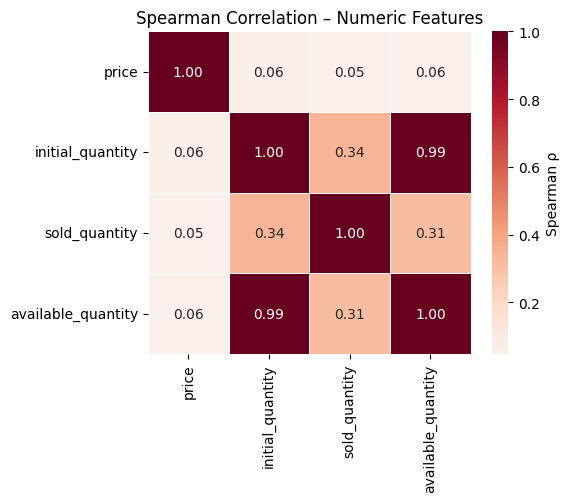

In [31]:
# Heatmap de correlación
corr = df_train[num_cols].corr(method='spearman')
plt.figure(figsize=(6, 5))
sns.heatmap(corr, cmap='RdBu_r', annot=True, fmt=".2f", center=0, square=True, linewidths=.5, cbar_kws={'label': 'Spearman ρ'})
plt.title('Spearman Correlation – Numeric Features')
plt.tight_layout()
plt.show()

##### Lectura del heat-map de correlación numérica

| Pareja | ρ (Spearman) | Qué significa | Acción |
|--------|-------------|---------------|--------|
| `initial_quantity` ↔ `available_quantity` | **0.99** | Son prácticamente la misma variable (la mayoría de los ítems aún no venden ninguna unidad). | Mantener **solo** `initial_quantity` como raw. |
| `sold_quantity` ↔ `initial_quantity` | 0.34 | Relación lógica: A más stock inicial, mayor potencial de ventas. | Conservar `sold_quantity`; importante para `sell_through_rate`. |
| `price` vs resto | ≈ 0.05–0.06 | El precio es **prácticamente independiente** del inventario. | Excelente: aporta informacion orthogonal. |

---

##### Nuevas Features numéricas propuestas

| Nueva feature | Fórmula | Propósito |
|---------------|---------|-----------|
| **`log_price`** | `np.log1p(price)` | Reducir skew en modelos lineales y facilitar splits en árboles. |
| **`sell_through_rate`** | `sold_quantity / (sold_quantity + available_quantity)` |  Proporción vendida → señal de condición (usado tiende a venderse distinto). |
| **`high_inventory_flag`** | `initial_quantity > 10` | Diferenciar vendedores mayoristas vs particulares. |
| **`low_price_flag`** | `price < 100` | Marcar productos de valor muy bajo (usado típico). |

In [32]:
def add_numeric_indicators(df: pd.DataFrame) -> pd.DataFrame:
    total_qty = df['sold_quantity'] + df['available_quantity']

    df['sell_through_rate'] = np.where(
        total_qty > 0,
        df['sold_quantity'] / total_qty,
        np.nan
    ).astype('float32')

    df['high_inventory_flag'] = (df['initial_quantity'] > 10).astype('int8')
    df['low_price_flag']      = (df['price'] < 100).astype('int8')

    df['log_price'] = np.log1p(df['price']).astype('float32')

    return df

In [33]:
# aplicar a train y test
df_train = add_numeric_indicators(df_train)
df_test  = add_numeric_indicators(df_test)

In [34]:
inspect_column(df_train, 'sell_through_rate', top_n=4)


— sell_through_rate —
dtype: float32 | n_missing: 0 | unique: 1542


,freq
sell_through_rate,
0.0,74834
0.5,3896
0.6666667,1180
0.33333334,661


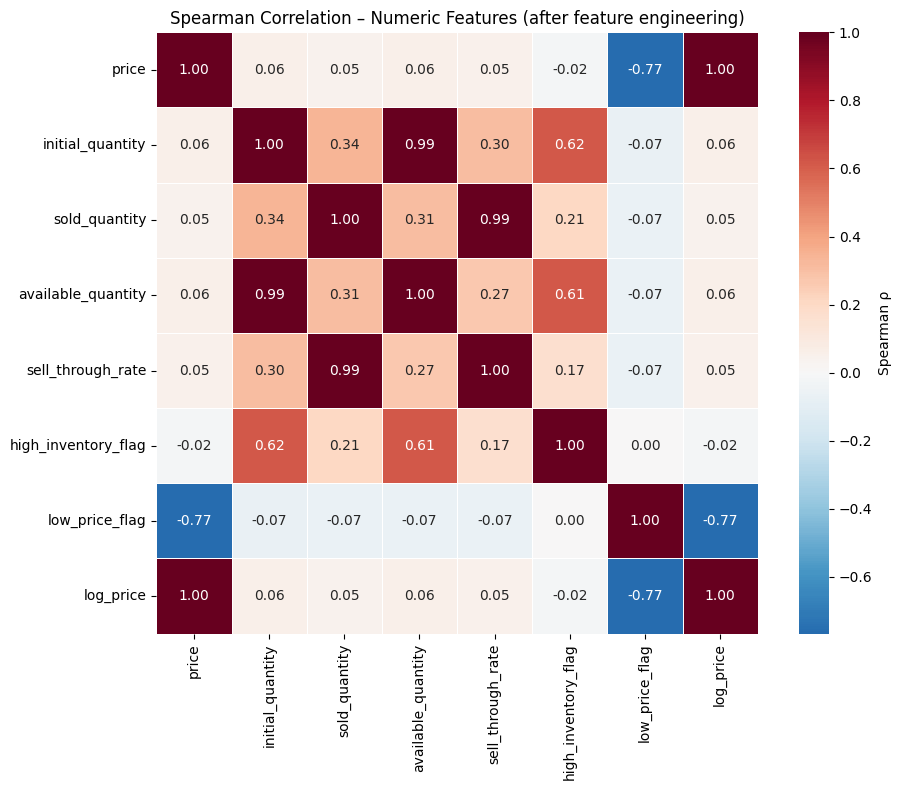

In [35]:
num_cols = df_train.select_dtypes(include='number').columns.tolist()

corr = df_train[num_cols].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap='RdBu_r',
    annot=True, fmt=".2f",
    center=0, square=True, linewidths=.5,
    cbar_kws={'label': 'Spearman ρ'}
)
plt.title('Spearman Correlation – Numeric Features (after feature engineering)')
plt.tight_layout()
plt.show()

##### Resumen

* `low_price_flag` con `price` ρ ≈ –0.77 → fuerte pero no perfecta; la flag captura
    “precio bajo” como categoría discreta que un valor continuo no refleja
    bien (sobre todo para árboles).
* `high_inventory_flag` correlaciona 0.62 con
  `initial_quantity`.  De nuevo, la intención es aislar el patrón “mayorista”
  independientemente del valor exacto de stock.

> Para **modelos árbol-basados** no hay problema en tener la feature continua **y** la versión binaria: el algoritmo decide si un split directo (`price ≤ 100`)
> es mejor que usar la flag.  
> El riesgo de multicolinealidad afecta principalmente a modelos lineales, que
> no usaremos como final.

##### Decisiones

1. **Quedarnos solo con `log_price`** (más estable) y descartar `price`.
2. **Mantener ambas flags** (`low_price_flag`, `high_inventory_flag`) porque aportan un corte semántico claro que puede ser útil.
3. `sell_through_rate` se descarta para evitar una feature que es casi función directa de `sold_quantity`.

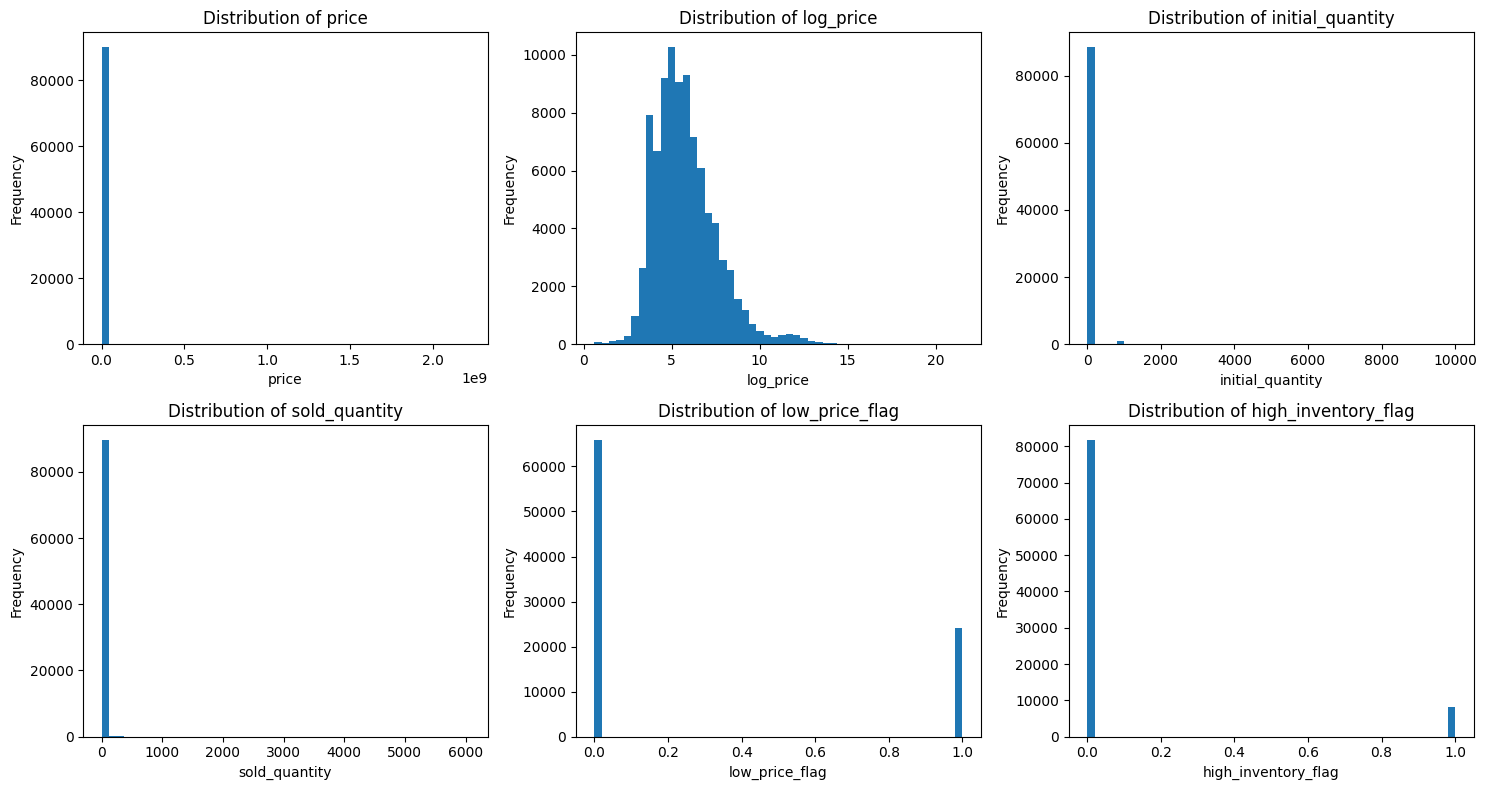

In [36]:
num_vars = [
    "price", "log_price",
    "initial_quantity", "sold_quantity",
    "low_price_flag", "high_inventory_flag",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, col in zip(axes, num_vars):
    ax.hist(df_train[col].dropna(), bins=50)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [37]:
# --- eliminar columnas redundantes / colineales ---
DROP_NUM_COLS = ['price', 'sell_through_rate']

df_train = df_train.drop(columns=DROP_NUM_COLS, errors='ignore')
df_test  = df_test.drop(columns=DROP_NUM_COLS,  errors='ignore')

In [38]:
# actualizar listado de numéricas
num_cols = df_train.select_dtypes(include='number').columns.tolist()
print("Columnas numéricas actuales:", num_cols)

Columnas numéricas actuales: ['initial_quantity', 'sold_quantity', 'available_quantity', 'high_inventory_flag', 'low_price_flag', 'log_price']


## 2.8 Features derivadas de las timestamps: 
1. `listing_duration_days` → Duración total de la publicación (días). Esta variable puede tener poder predictivo para diferenciar stock nuevo vs. usado.

In [39]:
df_train['listing_duration_days'] = (df_train['stop_time'] - df_train['start_time']).dt.days
inspect_column(df_train, 'listing_duration_days', top_n=3)
df_train.drop('listing_duration_days', axis=1, inplace=True)


— listing_duration_days —
dtype: int64 | n_missing: 0 | unique: 267


,freq
listing_duration_days,
60,87101
7,685
30,275


In [40]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    # Hora (0-23) y día de la semana (0-lunes, 6-domingo)
    df['start_hour'] = df['start_time'].dt.hour.astype('Int8')
    df['start_dow']  = df['start_time'].dt.weekday.astype('Int8')
    df['start_month'] = df['start_time'].dt.month.astype('Int8')
    return df

In [41]:
# Aplicamos a ambos splits
df_train = add_time_features(df_train)
df_test  = add_time_features(df_test)

In [42]:
inspect_column(df_train, 'start_month', top_n=4)


— start_month —
dtype: Int8 | n_missing: 0 | unique: 12


,freq
start_month,
9,44079
10,24852
8,20523
7,234


In [43]:
inspect_column(df_train, 'start_dow', top_n=7)


— start_dow —
dtype: Int8 | n_missing: 0 | unique: 7


,freq
start_dow,
1,16858
0,16100
2,14286
4,13112
3,11283
5,9528
6,8833


* **Día de la semana (`start_dow`; 0 = lunes).**

Más alta actividad lunes-martes (0-1) y una caída progresiva hasta domingo (6).

Negocios suelen subir lotes los lunes; los particulares reparten anuncios durante la semana. La señal parece relevante, así que mantenemos la variable.

In [44]:
inspect_column(df_train, 'start_hour', top_n=10)


— start_hour —
dtype: Int8 | n_missing: 0 | unique: 24


,freq
start_hour,
14,6554
15,6315
13,6049
18,5682
19,5680
21,5542
20,5540
16,5261
17,5261


In [45]:
# columnas de timestamp a descartar definitivamente
TS_RAW_COLS = ['start_time', 'stop_time', 'last_updated', 'date_created']

df_train = df_train.drop(columns=TS_RAW_COLS, errors='ignore')
df_test  = df_test.drop(columns=TS_RAW_COLS,  errors='ignore')

print("Timestamp cols eliminadas:", TS_RAW_COLS)
print("Shapes → Train:", df_train.shape, "| Test:", df_test.shape)

Timestamp cols eliminadas: ['start_time', 'stop_time', 'last_updated', 'date_created']
Shapes → Train: (90000, 32) | Test: (10000, 31)


##### Conclusiones sobre las variables temporales

* **`listing_duration_days`** → casi todos los avisos duran **60 días**; no discrimina.
* **`hours_until_last_update`** = diferencia de horas entre `last_updated` y `start_time` → la mayoría vale **0 h**, sin informacion valiosa.
* **`item_age_days`** = `NOW - start_time` → el dataset es de 2015, el valor absoluto carece de sentido hoy.
* **Valores que sí pueden aportar:**
  * **`start_hour`** – los particulares tienden a publicar de noche; las tiendas, en horario laboral.
  * **`start_dow`** – fines de semana vs días hábiles puede diferenciar inventario usado/nuevo.
* Por lo tanto **conservamos** `start_hour` y `start_dow` y **eliminamos** los timestamps crudos 
  (`start_time`, `stop_time`, `last_updated`, `date_created`).

## 2.9 Inspeccionamos y transformamos las features categóricas

In [46]:
# Columnas categoricas restantes
cat_cols = (df_train.select_dtypes(include=['object', 'string']).columns.difference(['condition']).tolist())

print(f"Total categorical features: {len(cat_cols)}")
print(cat_cols)

Total categorical features: 18
['attributes', 'buying_mode', 'category_id', 'currency_id', 'descriptions', 'listing_type_id', 'non_mercado_pago_payment_methods', 'parent_item_id', 'pictures', 'seller_address_city_name', 'seller_address_state_name', 'seller_id', 'shipping_mode', 'status', 'tags', 'title', 'variations', 'warranty']


### a. Variables simples (no listas o json)

#### 1. Variable 'buying_mode'

In [47]:
inspect_column(df_train, 'buying_mode', top_n=3)


— buying_mode —
dtype: object | n_missing: 0 | unique: 3


,freq
buying_mode,
buy_it_now,87311
classified,1982
auction,707


**Lectura**
* `buy_it_now` domina el dataset.
* Existen dos categorías minoritarias (`classified`, `auction`) que podrían aportar ligera señal: subastas y clasificados suelen usarse para ítems **usados** o de nicho.

**Decisión**
* Mantener la variable con **one-hot encoding** (`buy_it_now`, `classified`, `auction`).  Aun con el desequilibrio, modelos árbol-basados pueden captar la rareza de las clases minoritarias.
* No es necesario agrupar o binarizar: solo tres categorías y están limpias.

#### 2. Variable 'category_id'

In [48]:
inspect_column(df_train, 'category_id', top_n=10)


— category_id —
dtype: object | n_missing: 0 | unique: 10491


,freq
category_id,
MLA1227,4139
MLA2044,1759
MLA41287,829
MLA3530,685
MLA2038,601
MLA15171,522
MLA15328,446
MLA1383,416
MLA41269,399


In [49]:
# target_enc = ce.TargetEncoder(
#     cols=['category_id'],
#     smoothing=0.3                      # regulariza categorías raras
# )

# df_train['category_id_te'] = target_enc.fit_transform(
#     df_train[['category_id']], df_train['condition']
# ).values

# df_test['category_id_te'] = target_enc.transform(df_test[['category_id']]).values

# df_train = df_train.drop(columns=['category_id'])
# df_test  = df_test.drop(columns=['category_id'])

**Lectura**

* `category_id` es **muy dispersa**: pocas categorías tienen muchos productos y el resto forman una cola larguísima.
* One-hot directo generaría miles de columnas con alta sparsity → poco viable.
* Es probable que correlacione con la variable target (por ej. Electrodomésticos nuevos vs usados), así que conviene conservarla por ahora.

**Opciones de encoding**

* **Target Encoding** (media de “used” por categoría) | Captura relación con la target, manejable en 1 columna | Riesgo de leakage → usar CV / smoothing
* **Hash Encoding** (1 K-2 K buckets) | Simple, sin leakage, tamaño fijo | Pérdida de interpretabilidad, colisiones
* **Reduced One-Hot** (Top-N + “other”) | Interpretable para las 50-100 categorías más grandes | Pierde detalle de la cola larga

**Decisión**:  
* Empezar con **Target Encoding** con `CategoryEncoder` o `category_encoders.target`.

In [50]:
df_train[cat_cols].tail(5)

,attributes,buying_mode,category_id,currency_id,descriptions,listing_type_id,non_mercado_pago_payment_methods,parent_item_id,pictures,seller_address_city_name,seller_address_state_name,seller_id,shipping_mode,status,tags,title,variations,warranty
89995,<NA>,buy_it_now,MLA1227,ARS,[{'id': 'MLA1315520302-935540165'}],bronze,<NA>,MLA1130924824,"[{'size': '84x126', 'secure_url': 'https://a24...",capital federal,Capital Federal,9451922715,me2,active,[dragged_bids_and_visits],El Fin De Las Libertades - Benegas Lynch (h) -...,<NA>,Sin garantía
89996,<NA>,buy_it_now,MLA45559,ARS,[{'id': 'MLA6934377054-927516382'}],bronze,"[{'description': 'Transferencia bancaria', 'id...",MLA1317691731,"[{'size': '500x373', 'secure_url': 'https://a2...",Núñez,Capital Federal,4665194056,custom,paused,[dragged_bids_and_visits],Honda Wave Guardabarro Interior Trasero,<NA>,<NA>
89997,<NA>,buy_it_now,MLA81061,ARS,[{'id': 'MLA5644559490-902956215'}],bronze,"[{'description': 'Efectivo', 'id': 'MLAMO', 't...",MLA5098165723,"[{'size': '500x312', 'secure_url': 'https://a2...",La Matanza,Buenos Aires,3046474001,not_specified,active,[dragged_bids_and_visits],My Little Pony Completa Latino 4 Temporadas,<NA>,<NA>
89998,<NA>,buy_it_now,MLA48851,ARS,[{'id': 'MLA3520244075-935837959'}],bronze,"[{'description': 'Acordar con el comprador', '...",MLA3153148762,"[{'size': '225x225', 'secure_url': 'https://a2...",Trelew,Chubut,2373910598,not_specified,active,[dragged_bids_and_visits],Accidente Cerebrovascular En La Infancia Y Ado...,<NA>,La garantia solo responde en caso de fallas de...
89999,"[{'value_id': 'female', 'attribute_group_id': ...",buy_it_now,MLA109390,ARS,[{'id': 'MLA8241142190-943040617'}],free,<NA>,MLA3661010119,"[{'size': '500x281', 'secure_url': 'https://a2...",mataderos,Capital Federal,9518711314,not_specified,active,[dragged_bids_and_visits],Campera De Mujer Tucci Reversible,[{'attribute_combinations': [{'value_id': '920...,<NA>


#### 3. Variable 'category_id'

In [51]:
inspect_column(df_train, 'currency_id', top_n=3)


— currency_id —
dtype: object | n_missing: 0 | unique: 2


,freq
currency_id,
ARS,89496
USD,504


In [52]:
df_train['is_USD'] = (df_train['currency_id'] == 'USD').astype('int8')
df_test['is_USD']  = (df_test['currency_id']  == 'USD').astype('int8')

In [53]:
# Eliminamos la columna original
df_train = df_train.drop(columns=['currency_id'])
df_test  = df_test.drop(columns=['currency_id'])

**Lectura**

* Solo existen **dos monedas** y la distribución está fuertemente desbalanceada.
* Con tan solo dos categorías, el encoding es trivial y no generará sparsity.

**Decisión**

* Mantener la variable, codificándola como **flag binaria** `is_USD = (currency_id == 'USD').astype(int8)`.

#### 4. Variable 'listing_type_id'

In [54]:
inspect_column(df_train, 'listing_type_id', top_n=8)


— listing_type_id —
dtype: object | n_missing: 0 | unique: 7


,freq
listing_type_id,
bronze,56904
free,19260
silver,8195
gold_special,2693
gold,2170
gold_premium,765
gold_pro,13


**Lectura**

* El campo es **ordinal**: cada nivel es “mejor” que el anterior.  
* Vendedores con `gold`, `gold_pro`, `platinum` suelen ser tiendas oficiales o de alto volumen → correlación esperada con ítems **nuevos**.  
* One-hot perdería esa relación de orden; conviene codificarla como **ranking entero**.
* Los modelos de árbol manejarán bien este entero ordinal; la distancia entre niveles no introduce problemas como en modelos lineales.

In [55]:
# mapping
lt_map = {
    'free': 0,
    'bronze': 1,
    'silver': 2,
    'gold': 3,
    'gold_special': 4,
    'gold_premium': 5,
    'gold_pro': 6
}

df_train['listing_type_rank'] = (df_train['listing_type_id'].map(lt_map).fillna(-1).astype('Int8'))
df_test['listing_type_rank'] = (df_test['listing_type_id'].map(lt_map).fillna(-1).astype('Int8'))

In [56]:
# eliminar columna original
df_train = df_train.drop(columns=['listing_type_id'])
df_test  = df_test.drop(columns=['listing_type_id'])

In [57]:
df_train['listing_type_rank'].unique()

<IntegerArray>
[1, 2, 0, 4, 3, 5, 6]
Length: 7, dtype: Int8

#### 5. Variable 'parent_item_id'

In [58]:
inspect_column(df_train, 'parent_item_id', top_n=10)


— parent_item_id —
dtype: object | n_missing: 20690 | unique: 69310


,freq
parent_item_id,
MLA3661010119,1
MLA6553902747,1
MLA7727150374,1
MLA6561247998,1
MLA3133256685,1
MLA5588379672,1
MLA8744215055,1
MLA4442923846,1
MLA3677718570,1


**Lectura**

* **69 300 IDs únicas** (≈ 77 % del set) y el resto nulos.
* Cada ID aparece **1 sola vez** → no hay agrupación útil.
* Hash-encoding podría añadir ruido sin aportar señal discernible.

**Decisión**  
Eliminamos `parent_item_id`.

In [59]:
df_train = df_train.drop(columns=['parent_item_id'], errors='ignore')
df_test  = df_test.drop(columns=['parent_item_id'], errors='ignore')

#### 6. Variable 'seller_address_state_name'

In [60]:
inspect_column(df_train, 'seller_address_state_name', top_n=24)


— seller_address_state_name —
dtype: object | n_missing: 1 | unique: 24


,freq
seller_address_state_name,
Capital Federal,52143
Buenos Aires,31482
Santa Fe,2398
Córdoba,1727
Mendoza,400
Chubut,335
Entre Ríos,249
Tucumán,214
San Juan,132


**Lectura**

* Cardinalidad **baja–media** (24 categorías) pero distribución muy sesgada:
  Capital Federal y Buenos Aires concentran el 93 % del total.
* Los estados minoritarios (< 0.5 %) representan menos de 3 % del dataset; aún
  así podrían aportar señal (ej. provincias con más artículos usados).
* Para modelos árbol–basados, un **one-hot directo** con 24 columnas es
  manejable; sin embargo, las columnas de frecuencia < 0.5 % aportarán poca
  información y ocupan memoria.

**Decisión**

* **Reduced one-hot** (Top-K + “Other”) | Reduce sparsity, mantiene interpretabilidad | Asume que las provincias chicas se comportan igual
* Para esto **agrupamos provincias con < 1 %** en una categoría `Other_state`, luego **one-hot**.  Mantiene las dos grandes (Capital y Buenos Aires) y algunas intermedias.

In [61]:
# threshold: estados con menos del 1 % del total se agrupan en 'Other_state'
thresh = 0.01 * len(df_train)
state_counts = df_train['seller_address_state_name'].value_counts()

rare_states = state_counts[state_counts < thresh].index

In [62]:
df_train['state_reduced'] = df_train['seller_address_state_name'].replace(rare_states, 'Other_state')
df_test ['state_reduced'] = df_test ['seller_address_state_name'].replace(rare_states, 'Other_state')

In [63]:
# eliminamos columna original
df_train = df_train.drop(columns=['seller_address_state_name'])
df_test  = df_test.drop(columns=['seller_address_state_name'])

#### 7. Variable 'seller_address_city_name'

In [64]:
def normalize_city(text):
    """
    Normaliza un string de ciudad:
      • quita acentos/tildes
      • pasa a minúsculas
      • colapsa espacios múltiples
      • reemplaza espacio por '_' (guion bajo)
      • elimina espacios al inicio/fin
    Retorna NaN si la entrada era NaN.
    """
    if pd.isna(text):
        return pd.NA
    # quitar acentos
    text = unicodedata.normalize('NFKD', text)\
                       .encode('ascii', 'ignore')\
                       .decode('ascii')

    text = text.lower().strip()
    text = re.sub(r'\s+', '_', text)
    return text

In [65]:
df_train['city_norm'] = df_train['seller_address_city_name'].apply(normalize_city)
df_test['city_norm'] = df_test['seller_address_city_name'].apply(normalize_city)

In [66]:
inspect_column(df_train, 'city_norm', top_n=37)


— city_norm —
dtype: object | n_missing: 2 | unique: 2327


,freq
city_norm,
capital_federal,5857
buenos_aires,5808
caba,5309
palermo,3046
caballito,2710
belgrano,2112
rosario,1923
flores,1516
villa_crespo,1434


**Lectura**

* **Cardinalidad extremadamente alta** incluso tras la normalización (`≈ 2 300` ciudades únicas).
* Persisten variantes semánticamente iguales (`capital_federal`, `capital`, `caba`, `ciudad_autonoma_de_buenos_aires`, etc.), posiblemente porque el campo lo escribe cada vendedor libremente.
* Agregar un “rare_categories” englobaría cientos de aliases y seguiría introduciendo ruido → poca ganancia frente a **`state_reduced`**, que ya capta la señal geográfica a nivel provincia.

**Conclusión:**
* Para esta fase mantenemos solo la versión de provincia (`state_reduced`) y **descartamos `seller_address_city_name` (y `city_norm`)**.
* Si en una iteración futura vemos que aporta, podemos volver con técnicas más avanzadas (fuzzy clustering, embedding).

In [67]:
cols_to_drop = ['seller_address_city_name', 'city_norm']
df_train = df_train.drop(columns=cols_to_drop, errors='ignore')
df_test  = df_test.drop(columns=cols_to_drop, errors='ignore')

#### 8. Variable 'seller_id'

In [68]:
inspect_column(df_train, 'seller_id', top_n=15)


— seller_id —
dtype: object | n_missing: 0 | unique: 33281


,freq
seller_id,
5248662274,850
2015548469,654
7704929703,424
4631246902,408
8612126795,318
2266082781,302
6972484560,259
6846806944,251
4248718919,244


**Lectura**

* Top-1 vendedor | 850 avisos (0.9 %)
* Mediana avisos por vendedor | **2**
* % vendedores con ≤ 5 avisos | ~85 %

**Pros de conservar**
* Algunos vendedores son “tienda oficial” (casi todo **nuevo**) y otros venden exclusivamente **usado**; la ID captura ese patrón.

**Contras / riesgo**
* **Data leakage**: si un vendedor aparece en train y test, el modelo puede memorizar su “estilo” en lugar de generalizar sobre el producto.
* Cardinalidad muy alta → one-hot imposible; hash-encoding introduce colisiones y aún así puede memorizar.

**Estrategias posibles**
* **Hash encoding** (4 096 buckets) | Mantiene algo de señal, aumenta la dimensión pero es controlable | Alto riesgo de leakage (memoriza buckets si vendedor repite) | `hash(seller_id) % 4096`
* **Seller volume features** | `log1p(n_items_seller)` + flag `high_volume` | Bajo riesgo de leakeage (solo usa conteo, no la ID) | `df.groupby(seller_id).size()`

**Conclusión:**
1. **Eliminar `seller_id`** por ahora para evitar fuga explícita. 
2. Crear **`seller_volume`** (`log1p` del número de publicaciones del vendedor en *train*) y un flag `high_volume` (> 50 avisos). Esto da idea de profesionalidad sin revelar la identidad.
3. Se evita el data leakeage porque el conteo proviene **solo del train**; en test los vendedores nuevos se imputan con 0 avisos.

Si el modelo base no alcanza el valor necesario en la metrica de evaluación, se puede revisar luego.

In [69]:
seller_counts = df_train['seller_id'].value_counts()

df_train['seller_volume'] = df_train['seller_id'].map(seller_counts)
df_test ['seller_volume'] = df_test ['seller_id'].map(seller_counts).fillna(0)

In [70]:
df_train['seller_volume_log'] = np.log1p(df_train['seller_volume']).astype('float32')
df_test['seller_volume_log']  = np.log1p(df_test['seller_volume']).astype('float32')

In [71]:
df_train['seller_high_volume'] = (df_train['seller_volume'] > 50).astype('int8')
df_test ['seller_high_volume'] = (df_test ['seller_volume']  > 50).astype('int8')

In [72]:
# drop raw columns
df_train = df_train.drop(columns=['seller_id', 'seller_volume'])
df_test  = df_test.drop(columns=['seller_id', 'seller_volume'])

print(df_train[['seller_volume_log', 'seller_high_volume']].head())

   seller_volume_log  seller_high_volume
0           0.693147                   0
1           1.098612                   0
2           3.465736                   0
3           1.609438                   0
4           4.343805                   1


#### 9. Variable 'shipping_mode'

In [73]:
inspect_column(df_train, 'shipping_mode', top_n=5)


— shipping_mode —
dtype: object | n_missing: 0 | unique: 4


,freq
shipping_mode,
me2,46059
not_specified,40725
custom,3130
me1,86


**Lectura**
* *me2* → logística completa de Mercado Envíos (suele usarla un vendedor formal).
* *not_specified* → vendedor define su propio método; mezcla de nuevos y usados.
* *custom* → logística acordada manualmente; típico de vendedores pequeños → posible correlación con **usado**.
* *me1* está prácticamente extinta (servicio antiguo).

**Decisión**
* Encodar el resultado con **One-Hot** (`me2`, `not_specified`, `custom`, `me1`). → 4 columnas, manejable e interpretable.

#### 10. Variable 'status'

In [74]:
inspect_column(df_train, 'status', top_n=5)


— status —
dtype: object | n_missing: 0 | unique: 4


,freq
status,
active,86116
paused,3863
closed,20
not_yet_active,1


**Lectura**
* `active` domina claramente el set.  
* `paused` (publicación suspendida temporalmente) aparece en ~4 % y podría correlacionar con **usado** (stock agotado, vendedor sin reputación, etc.).
* `closed` y `not_yet_active` son extremadamente raras; mantenerlas como dummies independientes añade columnas casi vacías.

**Decisión**
* Agrupar las dos categorías ultrararas (`closed`, `not_yet_active`) en **`other_status`**.  
* Aplicar **One-Hot Encoding** a las tres categorías resultantes: `active`, `paused`, `other_status`.

Esto conserva la señal de “no activo” sin crear columnas muy dispersas.

In [75]:
# agrupar clases raras
df_train['status_red'] = df_train['status'].replace({'closed': 'other_status', 'not_yet_active': 'other_status'})
df_test['status_red'] = df_test['status'].replace({'closed': 'other_status', 'not_yet_active': 'other_status'})

In [76]:
# eliminar la original
df_train = df_train.drop(columns=['status'])
df_test  = df_test.drop(columns=['status'])

print("Distribución reducida:")
display(df_train['status_red'].value_counts(normalize=True).mul(100).round(2).to_frame('%'))

Distribución reducida:


,%
status_red,
active,95.68
paused,4.29
other_status,0.02


#### 11. Variable 'warranty'

In [77]:
inspect_column(df_train, 'warranty', top_n=5)


— warranty —
dtype: object | n_missing: 54786 | unique: 9535


,freq
warranty,
Sí,5107
Sin garantía,4907
SI,545
6 meses,489
6 MESES,361


Creamos una tabla para visualizar como se distribuye nuestra variable target, con respecto a los diferentes valores de la variable warranty (luego de normalizar sus valores).

In [78]:
def quick_norm(s):
    if pd.isna(s):
        return 'missing'
    s = unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('ascii')
    return re.sub(r'\s+', ' ', s.lower()).strip()

# normalizar warranty
df_tmp = df_train.copy()
df_tmp['warr_norm'] = df_tmp['warranty'].map(quick_norm)

# top-50 valores más frecuentes
top_n = 50
top_vals = df_tmp['warr_norm'].value_counts().head(top_n).index

# tabla cruzada (conteo de filas)
tbl = (
    df_tmp[df_tmp['warr_norm'].isin(top_vals)]
      .pivot_table(index='warr_norm',
                   columns='condition',
                   aggfunc='size',
                   fill_value=0)
      .rename_axis(None, axis=1)
)

tbl['total']    = tbl.sum(axis=1)
tbl['pct_used'] = (tbl['used'] / tbl['total']).round(3)

tbl = tbl.sort_values('total', ascending=False)

display(tbl.reset_index().rename(columns={'warr_norm': 'warranty'}).head(5))

,warranty,new,used,total,pct_used
0,missing,26479,28307,54786,0.517
1,si,2871,3407,6278,0.543
2,sin garantia,1701,3219,4920,0.654
3,6 meses,927,27,954,0.028
4,3 meses,377,21,398,0.053


**Lectura**  
* `warranty` tiene **> 9 500** formas de expresar la garantia (tildes, mayúsculas, frases de marketing) y **61 %** de nulos.
* Pocos registros indicaban un plazo claro (“6 meses”, “1 año”, “90 días”); la mayoría sólo decía “sí / con garantía” o mensajes de reputación.
* Cruce con la *target* → los ítems **used** se concentran en “sin garantía”, mientras los **new** predominan en plazos de 3-36 meses.

**Decisión & Feature Engineering**  
1. **Normalizar texto** (minúsculas, sin tildes).  
2. **Regex**:  
   * “sin/no garantía” → `warranty_months = -1`  
   * Plazo explícito (años/meses/días) → convertir a **meses** (>0).  
   * Garantía genérica sin plazo (“con garantía”, “de fábrica”, etc.) → `warranty_months = 0`.  
3. Crear flag **`warranty_duration_specified`** = 1 si `warranty_months ≥ 0`.

En el modelo:  
* `warranty_months` entra como numérica (−1, 0, 3, 6, 12, …).  
* `warranty_duration_specified` como variable binaria.

De este modo reemplazamos la columna `warranty` por dos features densas, interpretables y con la señal “sin / con / cuánto”.

In [79]:
def normalize_txt(s:str) -> str:
    """acentos→ascii, lower, trim, colapsa espacios"""
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    return re.sub(r'\s+', ' ', s.lower()).strip()

RE_UNITS = {
    'year' : re.compile(r'(\d+)\s*a(?:n|ñ)o?s?'),
    'month': re.compile(r'(\d+)\s*mes(?:es)?'),
    'day'  : re.compile(r'(\d+)\s*d[ií]a?s?'),
}

# estos son los patrones que buscamos filtrar
NEG_NO_GARANT = re.compile(r'\b(?:sin|no)\s+garant', re.I)

KEY_HAS_WARRANTY = re.compile(
    r'(garant\w*.*\b(?:si|con|fabric|fabr|oficial|total)\b)|'
    r'\b(?:de|del)\s+fabr(?:ic(?:a|ante)?|)\b',
    re.I
)

def warranty_to_months(text) -> int:
    """
    -1: sin garantía
     0: tiene garantía sin duración explícita
    >0: meses
    """
    if pd.isna(text):
        return -1
    txt = normalize_txt(str(text))

    # sin garantía
    if txt in {'', 'na', 'n/a'} or NEG_NO_GARANT.search(txt):
        return -1

    # duración explícita
    for unit, regex in RE_UNITS.items():
        m = regex.search(txt)
        if m:
            num = int(m.group(1))
            if unit == 'year':
                return num * 12
            if unit == 'day':
                return max(1, round(num / 30))
            return num  # months

    # garantía sin duración
    if KEY_HAS_WARRANTY.search(txt):
        return 0

    return -1

In [80]:
# ---------- aplicar ----------
for df in (df_train, df_test):
    months = df['warranty'].map(warranty_to_months).astype('int16')
    df['warranty_months'] = months
    df['warranty_duration_specified'] = (months >= 0).astype('int8')

In [81]:
# Distribución NEW vs USED para las nuevas features warranty
def dist_table(feature: str, df: pd.DataFrame) -> pd.DataFrame:
    """Devuelve conteo y % used por valor de `feature`."""
    ct = pd.crosstab(df[feature], df['condition'])
    ct['total']    = ct.sum(axis=1)
    ct['pct_used'] = (ct['used'] / ct['total']).round(3)
    return ct.sort_index()

In [82]:
# 1) Duración en meses (–1 = sin garantía, 0 = sin duración, >0 meses)
tbl_months = dist_table('warranty_months', df_train)
display(tbl_months.sort_values('total', ascending=False).head(15))

condition,new,used,total,pct_used
warranty_months,,,,
-1,39111,40753,79864,0.510
0,2264,386,2650,0.146
6,2543,52,2595,0.020
12,1659,43,1702,0.025
3,957,72,1029,0.070
1,569,174,743,0.234
24,252,5,257,0.019
60,254,1,255,0.004
2,194,13,207,0.063


In [83]:
# 2) Flag “¿tiene duración especificada?” (1 = sí, 0 = no)
tbl_flag   = dist_table('warranty_duration_specified', df_train)
display(tbl_flag.sort_values('total', ascending=False).head(2))

condition,new,used,total,pct_used
warranty_duration_specified,,,,
0,39111,40753,79864,0.510
1,9241,895,10136,0.088


In [84]:
# eliminar columna bruta
df_train = df_train.drop(columns=['warranty'])
df_test  = df_test.drop(columns=['warranty'])

### b. Variables tipo listas o json

In [85]:
def flatten_column(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Fully flatten *every* element of df[col] into a tidy DataFrame.

    • Lists / dicts           → expanded row-by-row via json_normalize.
    • JSON strings            → parsed first.
    • Scalars (incl. NaN)     → wrapped into a dict so they survive.
    • Keeps row index in '__row' for traceability.
    """
    records = []

    for idx, x in df[col].items():
        # decode JSON strings (ignore failures -> keep as raw string)
        if isinstance(x, str):
            try:
                x = json.loads(x)
            except json.JSONDecodeError:
                pass

        # make iterable
        if is_scalar(x):
            x = [x]

        # expand each element
        for item in x:
            if is_scalar(item) or item is None or (isinstance(item, float) and np.isnan(item)):
                key = col[:-1] if col.endswith('s') else f"{col}_value"
                records.append({'__row': idx, key: item})
            elif isinstance(item, dict):
                rec = item.copy()
                rec['__row'] = idx
                records.append(rec)
            else:
                # any other iterable → stringify
                key = col[:-1] if col.endswith('s') else f"{col}_value"
                records.append({'__row': idx, key: str(item)})

    return pd.json_normalize(records, sep='_')

#### 12. Variable 'attributes'

In [86]:
inspect_column(df_train, 'attributes', top_n=3)


— attributes —
dtype: object | n_missing: 78850 | unique: 3117


,freq
attributes,
"[{'value_id': 'female', 'attribute_group_id': 'DFLT', 'name': 'Género', 'value_name': 'Mujer', 'attribute_group_name': 'Otros', 'id': 'GENDER'}, {'value_id': 'Season-All-Season', 'attribute_group_id': 'FIND', 'name': 'Season', 'value_name': 'All-Season', 'attribute_group_name': 'Ficha técnica', 'id': 'Season'}]",1039
"[{'value_id': 'female', 'attribute_group_id': 'DFLT', 'name': 'Género', 'value_name': 'Mujer', 'attribute_group_name': 'Otros', 'id': 'GENDER'}, {'value_id': 'Season-All-Season', 'attribute_group_id': 'DFLT', 'name': 'Season', 'value_name': 'All-Season', 'attribute_group_name': 'Otros', 'id': 'Season'}]",997
"[{'value_id': 'male', 'attribute_group_id': 'DFLT', 'name': 'Género', 'value_name': 'Hombre', 'attribute_group_name': 'Otros', 'id': 'GENDER'}, {'value_id': 'Season-All-Season', 'attribute_group_id': 'FIND', 'name': 'Season', 'value_name': 'All-Season', 'attribute_group_name': 'Ficha técnica', 'id': 'Season'}]",921


In [87]:
flat_attr = flatten_column(df_train, 'attributes')

In [88]:
flat_attr.isna().sum()

__row                        0
attribute               184765
value_id                 78850
attribute_group_id       78850
name                     78850
value_name               78850
attribute_group_name     78850
id                       78850
dtype: int64

In [89]:
flat_attr[flat_attr["name"].notna()].head()

,__row,attribute,value_id,attribute_group_id,name,value_name,attribute_group_name,id
8,8,NaN,,DFLT,Número de pieza,37123,Otros,PART_NUMBER
9,9,NaN,female,DFLT,Género,Mujer,Otros,GENDER
10,9,NaN,Season-Spring-Summer,FIND,Season,Spring-Summer,Ficha técnica,Season
13,12,NaN,,DFLT,Número pieza,2,Otros,MLA-PART_NUMBER
14,13,NaN,female,DFLT,Género,Mujer,Otros,GENDER


**Lectura**  
* Presente sólo en **≈ 13 %** de los ítems (≈ 78 k nulos).  
* Cuando existe, contiene una **lista JSON** con pares `{"name": …, "value_name": …}`.  
* El *flatten* arroja **> 3 100** combinaciones de nombre — muy disperso: el atributo más frecuente (“Género”) aparece en apenas ~1 % de las filas.  
* Extraer y hacer one-hot en cada campo crearía miles de columnas super esparsas.

**Decisión**  
* Generar dos features compactas:  
  * **`n_attributes`** → recuento de elementos de la lista.
  * **`has_attributes`** → flag binario (`n_attributes > 0`).
* Descartar el JSON original (`attributes`) en este primer ciclo.
* Dejar para una fase 2 donde se parseen atributos clave (p.ej. *brand*, *color*) si el *boost* de performance lo justifica.

In [90]:
# ------- engineering -------
for df in (df_train, df_test):
    df['n_attributes']  = df['attributes'].apply(lambda x: len(x) if isinstance(x, list) else 0).astype('int16')
    df['has_attributes'] = (df['n_attributes'] > 0).astype('int8')

In [91]:
# opcional: eliminar la lista para no pasarla al pipeline
df_train.drop(columns='attributes', inplace=True)
df_test.drop(columns='attributes',  inplace=True)

#### 13. Variable 'descriptions'

In [92]:
inspect_column(df_train, 'descriptions', top_n=3)


— descriptions —
dtype: object | n_missing: 2417 | unique: 87583


,freq
descriptions,
"[""{'id': 'MLA8241142190-943040617'}""]",1
"[""{'id': 'MLA4695330653-912855983'}""]",1
"[""{'id': 'MLA7160447179-930764806'}""]",1


**Lectura**
* Cada registro guarda una **lista JSON** con uno o más IDs de bloque de descripción (*p.ej.* `{"id":"MLA8241142190-943040617"}`); no contiene el texto en sí.
* Hay **87 583 valores distintos** (prácticamente uno por ítem) → cardinalidad extrema y nulo poder de agrupación.
* Sólo **2.7 %** de filas carecen de lista (`NaN`).

**Decisión**
* Extraer una única informacion compacta:
  * **`has_description`** – flag binario (`1` si la lista existe y no está vacía, `0` en caso contrario).
* Descartar el campo JSON original (`descriptions`) para evitar leakage.

In [93]:
# ------- engineering -------
for df in (df_train, df_test):
    df['has_description'] = df['descriptions'].apply(lambda x: int(bool(isinstance(x, list) and len(x)))).astype('int8')

In [94]:
# opcional: eliminar el JSON
df_train.drop(columns='descriptions', inplace=True)
df_test.drop(columns='descriptions',  inplace=True)

#### 14. Variable 'non_mercado_pago_payment_methods'

In [95]:
inspect_column(df_train, 'non_mercado_pago_payment_methods', top_n=3)


— non_mercado_pago_payment_methods —
dtype: object | n_missing: 27531 | unique: 173


,freq
non_mercado_pago_payment_methods,
"[{'description': 'Transferencia bancaria', 'id': 'MLATB', 'type': 'G'}, {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}]",20303
"[{'description': 'Transferencia bancaria', 'id': 'MLATB', 'type': 'G'}, {'description': 'Tarjeta de crédito', 'id': 'MLAOT', 'type': 'N'}, {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}]",18678
"[{'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}]",12915


In [96]:
flat_nmppm = flatten_column(df_train, 'non_mercado_pago_payment_methods')

In [97]:
flat_nmppm.head()

,description,id,type,__row,non_mercado_pago_payment_method
0,Transferencia bancaria,MLATB,G,0,NaN
1,Acordar con el comprador,MLAWC,G,0,NaN
2,Efectivo,MLAMO,G,0,NaN
3,Transferencia bancaria,MLATB,G,1,NaN
4,Efectivo,MLAMO,G,1,NaN


In [98]:
flat_nmppm.isna().sum()

description                         27531
id                                  27531
type                                27531
__row                                   0
non_mercado_pago_payment_method    169866
dtype: int64

In [99]:
flat_nmppm.description.unique()

array(['Transferencia bancaria', 'Acordar con el comprador', 'Efectivo',
       'Tarjeta de crédito', nan, 'MasterCard', 'Mastercard Maestro',
       'Visa Electron', 'Contra reembolso', 'Visa', 'Diners',
       'American Express', 'Giro postal', 'MercadoPago',
       'Cheque certificado'], dtype=object)

In [100]:
flat_nmppm.id.unique()

array(['MLATB', 'MLAWC', 'MLAMO', 'MLAOT', nan, 'MLAMC', 'MLAMS', 'MLAVE',
       'MLACD', 'MLAVS', 'MLADC', 'MLAAM', 'MLAWT', 'MLAMP', 'MLABC'],
      dtype=object)

In [101]:
# ---------------- helpers ----------------
CARD_PAT = re.compile(r'visa|master|american|diners|tarjeta', re.I)
PICKUP_PAT = re.compile(r'(acordar|reembolso)', re.I)

def summarize_pay_methods(methods):
    """Devuelve (#métodos, has_card, has_pickup)."""
    if not isinstance(methods, list) or len(methods) == 0:
        return 0, 0, 0

    descs = [m.get('description', '') for m in methods]
    n_methods   = len(descs)
    has_card    = int(any(CARD_PAT.search(d)   for d in descs))
    has_pickup  = int(any(PICKUP_PAT.search(d) for d in descs))
    return n_methods, has_card, has_pickup

# ---------------- aplicar ----------------
for df in (df_train, df_test):
    triples = df['non_mercado_pago_payment_methods'].apply(summarize_pay_methods)
    df['n_extra_pay_methods'] = triples.map(lambda t: t[0]).astype('int8')
    df['accepts_card']        = triples.map(lambda t: t[1]).astype('int8')
    df['pay_on_pickup']       = triples.map(lambda t: t[2]).astype('int8')

In [102]:
df_train.groupby(['n_extra_pay_methods', 'accepts_card', 'pay_on_pickup'])[['condition']].count().head(16)

condition
n_extra_pay_methods accepts_card pay_on_pickup           
0                   0            0                  27531
1                   0            0                  13484
                                 1                    939
                    1            0                    171
2                   0            0                  20324
                                 1                    858
                    1            0                   1504
                                 1                      2
3                   0            0                    836
                                 1                   2476
                    1            0                  18682
                                 1                     36
4                   0            0                      8
                                 1                    527
                    1            0                    128
                                 1                   1619

**Lectura**
* **% nulos** | 30.6 % (`NaN` ⇒ sin métodos extra). **Únicos (listas)** | 173 combinaciones
* **Valores típicos** | `['Transferencia bancaria', 'Efectivo']`, `[...] Tarjeta de crédito ...`, etc.
* **Contenido** | Lista-JSON con 1 – 4 métodos (*transferencia*, *efectivo*, *cheque*, …).

* Cada combinación es **específica de la publicación** → cardinalidad media-alta y difícil de one-hot directamente.  
* La señal relevante es **“¿Acepta un medio de pago externo a Mercado Pago?”**.  
* El 69 % de los ítems traen lista vacía (`[]`) ⇒ valor informativo del *flag*.

**Decisión**
* Extraer **flag binario** `has_other_payment` = 1 si la lista contiene al menos un método, 0 si vacía/NaN.
* `n_extra_pay_methods` | Nº de métodos distintos listados (0, 1, 2, …) | ↑ variedad → vendedor “pro”; usados suelen tener 0 – 1.
* `accepts_card` | 1 si incluye **cualquier** tarjeta (`visa`, `mastercard`, *etc.*) | Tarjeta ≈ vendedor formal (stock nuevo).
* `pay_on_pickup` | 1 si aparece `acordar con el comprador` / `contra reembolso` | Modalidad típica de particulares.
* Eliminar JSON original `non_mercado_pago_payment_methods`.

In [103]:
# drop original column
df_train.drop(columns='non_mercado_pago_payment_methods', inplace=True)
df_test.drop(columns='non_mercado_pago_payment_methods',  inplace=True)

#### 15. Variable 'pictures'

In [104]:
inspect_column(df_train, 'pictures', top_n=3)


— pictures —
dtype: object | n_missing: 703 | unique: 89293


,freq
pictures,
"[{'size': '250x250', 'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/6279-MLApp_27_21489919_1-O.jpg', 'max_size': '250x250', 'url': 'http://mla-s1-p.mlstatic.com/6279-MLApp_27_21489919_1-O.jpg', 'quality': '', 'id': '6279-MLApp_27_21489919_1'}]",4
"[{'size': '250x250', 'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/6270-MLApp_27_19602074_1-O.jpg', 'max_size': '250x250', 'url': 'http://mla-s1-p.mlstatic.com/6270-MLApp_27_19602074_1-O.jpg', 'quality': '', 'id': '6270-MLApp_27_19602074_1'}]",2
"[{'size': '500x375', 'secure_url': 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/9874-MLA1395917367_122013-O.jpg', 'max_size': '1024x768', 'url': 'http://mla-s2-p.mlstatic.com/9874-MLA1395917367_122013-O.jpg', 'quality': '', 'id': '9874-MLA1395917367_122013'}, {'size': '500x375', 'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/9824-MLA1395917367_122013-O.jpg', 'max_size': '1024x768', 'url': 'http://mla-s1-p.mlstatic.com/9824-MLA1395917367_122013-O.jpg', 'quality': '', 'id': '9824-MLA1395917367_122013'}, {'size': '500x375', 'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/9817-MLA1395917367_122013-O.jpg', 'max_size': '1024x768', 'url': 'http://mla-s1-p.mlstatic.com/9817-MLA1395917367_122013-O.jpg', 'quality': '', 'id': '9817-MLA1395917367_122013'}, {'size': '500x375', 'secure_url': 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/9825-MLA1395917367_122013-O.jpg', 'max_size': '1024x768', 'url': 'http://mla-s2-p.mlstatic.com/9825-MLA1395917367_122013-O.jpg', 'quality': '', 'id': '9825-MLA1395917367_122013'}, {'size': '500x375', 'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/9809-MLA1395917367_122013-O.jpg', 'max_size': '1024x768', 'url': 'http://mla-s1-p.mlstatic.com/9809-MLA1395917367_122013-O.jpg', 'quality': '', 'id': '9809-MLA1395917367_122013'}]",1


In [105]:
flat_pic = flatten_column(df_train, 'pictures')

In [106]:
flat_pic['size'].nunique()

13328

In [107]:
flat_pic.isna().sum()

size             703
secure_url       703
max_size         703
url              703
quality          703
id               703
__row              0
picture       264432
dtype: int64

In [108]:
flat_pic.head()

,size,secure_url,max_size,url,quality,id,__row,picture
0,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,,5386-MLA4695330653_052013,0,NaN
1,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1200x900,http://mla-s1-p.mlstatic.com/5361-MLA469533065...,,5361-MLA4695330653_052013,0,NaN
2,499x334,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,951x637,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,,23223-MLA7160447179_022015,1,NaN
3,500x375,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,1024x768,http://mla-s2-p.mlstatic.com/23273-MLA71604471...,,23273-MLA7160447179_022015,1,NaN
4,500x375,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1024x768,http://mla-s1-p.mlstatic.com/23205-MLA71604471...,,23205-MLA7160447179_022015,1,NaN


**Lectura**
* Registros con **NaN** | **703** (~0,8 %)
* Publicaciones con lista vacía `[]` | **89 294** (~99 %)
* Ítems con ≥ 1 foto | **706** (~0,8 %)
* Distintos tamaños (`size`) detectados tras *flatten* | **13 328**


* La columna es una **lista de diccionarios** con metadatos de cada foto.
* La gran mayoría de los ítems no declara fotos extra; los que sí lo hacen son muy pocos.
* Los campos internos (`size`, `url`, `quality`, `id`, …) tienen altísima cardinalidad, lo que los hace poco manejables como features directos.

**Decisión & Feature Engineering**
* **Contador de imagenes** | `n_pictures` = número de elementos de la lista. Sirve para discriminar anuncios muy ilustrados (stock nuevo) de los que sólo suben la imagen principal.
* **Descartar payload** | Campos internos (`size`, `url`, `quality`, `id`, etc.) se desechan: cardinalidad enorme, riesgo de *leakage* y beneficio dudoso.

In [109]:
# Feature derivada
for df in (df_train, df_test):
    df['n_pictures'] = df['pictures'].apply(lambda x: len(x) if isinstance(x, list) else 0).astype('int16')

In [110]:
# Eliminamos la columna bruta
df_train.drop(columns='pictures', inplace=True)
df_test.drop(columns='pictures',  inplace=True)

#### 15. Variable 'tags'

In [111]:
inspect_column(df_train, 'tags', top_n=7)


— tags —
dtype: object | n_missing: 22412 | unique: 7


,freq
tags,
['dragged_bids_and_visits'],65315
"['good_quality_thumbnail', 'dragged_bids_and_visits']",1191
['dragged_visits'],464
['good_quality_thumbnail'],346
"['dragged_visits', 'free_relist']",259
"['poor_quality_thumbnail', 'dragged_bids_and_visits']",10
['poor_quality_thumbnail'],3


In [112]:
flat_tags = flatten_column(df_train, 'tags')

In [113]:
flat_tags.head()

,__row,tag
0,0,dragged_bids_and_visits
1,1,<NA>
2,2,dragged_bids_and_visits
3,3,<NA>
4,4,dragged_bids_and_visits


In [114]:
flat_tags.tag.value_counts()

tag
dragged_bids_and_visits    66516
good_quality_thumbnail      1537
dragged_visits               723
free_relist                  259
poor_quality_thumbnail        13
Name: count, dtype: int64

**Lectura** 
* **Distribución muy desequilibrada**:  
  * `'dragged_bids_and_visits'` representa **≈ 73 %** de todos los registros.  
  * Otras etiquetas escasas: `good_quality_thumbnail` (~ 1.7 %) | `dragged_visits` (< 1 %) | `free_relist`, `poor_quality_thumbnail` y combinaciones varias (< 0.5 % cada una). 
* **Semántica** – todas son *flags* internas de Mercado Libre sobre calidad de foto, performance o tipo de relistado; ninguna aporta información granular sobre el artículo en sí.
* **Valores nulos**: ~ 22 k publicaciones (25 %) carecen completamente de lista de tags.

**Decisión & feature engineering**
* **`has_tags` (binario)** | 1 si la lista contiene al menos una etiqueta, 0 si está vacía / NaN. Captura la señal de que MELI añadió alguna marca interna.
* **Agrupar etiquetas raras** | Como cada tag individual es ultra-poco frecuente, no vale la pena one-hot. Se pueden fusionar todas en la categoría **`other_tag`** para un conteo simple.
* **Omitir payload** | No conservar la lista real ni los nombres originales; riesgo de esparcir columnas muy sparsas por mínima ganancia.

Con esto la variable queda reducida a una señal binaria de “publicación con marca interna” y un **count** opcional (`n_tags`) sin explosión de cardinalidad.

In [115]:
def _parse_tags(val):
    """
    Devuelve lista de tags ([] si NaN, '[]', error de parseo, etc.).
    Maneja correctamente cuando el elemento ya es lista.
    """
    # 1) si ya viene como lista → tal cual
    if isinstance(val, list):
        return val
    
    # 2) NaN / None
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return []

    # 3) cadena: intentar evaluar '[...]'
    try:
        parsed = ast.literal_eval(val) if isinstance(val, str) else []
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

def add_tag_features(df: pd.DataFrame) -> pd.DataFrame:
    tag_lists = df['tags'].apply(_parse_tags)

    df['has_tags'] = (tag_lists.str.len() > 0).astype('int8')
    df['n_tags']   = tag_lists.str.len().astype('int16')

    # elimina la lista original para no dejar datos semi-estructurados
    df.drop(columns='tags', inplace=True, errors='ignore')
    return df

In [116]:
# ---------------- aplicar ----------------
df_train = add_tag_features(df_train)
df_test  = add_tag_features(df_test)

In [117]:
df_train.groupby(['has_tags', 'n_tags'])['condition'].count()

has_tags  n_tags
0         0         22412
1         1         66128
          2          1460
Name: condition, dtype: int64